In [1]:
#Library import
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('brown')

from textblob import TextBlob
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, ENGLISH_STOP_WORDS

from gensim.corpora.dictionary import Dictionary

import spacy

from collections import Counter

import time
import re
import sys
import requests
from pathlib import Path

from bs4 import BeautifulSoup

from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.action_chains import ActionChains

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/miguel.d.ferrusca/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/miguel.d.ferrusca/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package brown to
[nltk_data]     /Users/miguel.d.ferrusca/nltk_data...
[nltk_data]   Package brown is already up-to-date!
/Users/miguel.d.ferrusca/Documents/ironhack/lib/python3.9/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [2]:
pd.options.display.max_rows = 100

In [3]:
# Loading datasets
df = pd.read_csv("data/Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19.csv")
#df2 = pd.read_csv('data/Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products.csv')

## Data Exploration

In [4]:
df.head(2)

,id,dateAdded,dateUpdated,name,asins,brand,categories,primaryCategories,imageURLs,keys,...,reviews.numHelpful,reviews.rating,sourceURLs,reviews.sourceURLs,reviews.text,reviews.title,reviews.username,reviews.rating.1,Sentiment,Category
0,AVpfhcniLJeJML43-t4G,2015-10-30T10:58:06Z,2019-04-22T10:21:26Z,Expanding Accordion File Folder Plastic Portab...,"B0002LCUZK,B010CEC6MI,B01B25NN64",Amazonbasics,"Office,File Jackets & File Pockets,File Folder...",Office Supplies,https://i.ebayimg.com/images/g/qAwAAOSwptJab16...,expandingaccordionfilefolderplasticportabledoc...,...,NaN,5,http://www.ebay.com/itm/Expanding-File-Tabs-Fo...,https://www.ebay.com/itm/Expanding-Accordion-F...,Exactly what I needed.,Folder,99kurama99,5,Positive,Accuracy
1,AWFFfd9KIwln0LfXiOe0,2018-01-30T04:58:34Z,2019-04-25T04:27:39Z,Fire TV Stick Streaming Media Player Pair Kit,B00ZV9RDKK,Amazon,"Electronics,TVs Entertainment,Featured Brands,...",Electronics,https://static.bhphoto.com/images/smallimages/...,"0848719083781,firetvstickstreamingmediaplayerp...",...,1.0,5,https://www.bhphotovideo.com/c/product/1395909...,https://www.newegg.com/Product/Product.aspx?It...,Pros: Allows you to cut your cable. With many ...,"Quick, Simple, Easy to use and SAVE YOU MONEY!",Cameron G.,5,Positive,Value


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28332 entries, 0 to 28331
Data columns (total 27 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   28332 non-null  object 
 1   dateAdded            28332 non-null  object 
 2   dateUpdated          28332 non-null  object 
 3   name                 28332 non-null  object 
 4   asins                28332 non-null  object 
 5   brand                28332 non-null  object 
 6   categories           28332 non-null  object 
 7   primaryCategories    28332 non-null  object 
 8   imageURLs            28332 non-null  object 
 9   keys                 28332 non-null  object 
 10  manufacturer         28332 non-null  object 
 11  manufacturerNumber   28332 non-null  object 
 12  reviews.date         28332 non-null  object 
 13  reviews.dateSeen     28332 non-null  object 
 14  reviews.didPurchase  9 non-null      object 
 15  reviews.doRecommend  16086 non-null 

In [6]:
df.shape

(28332, 27)

## Initial analysis

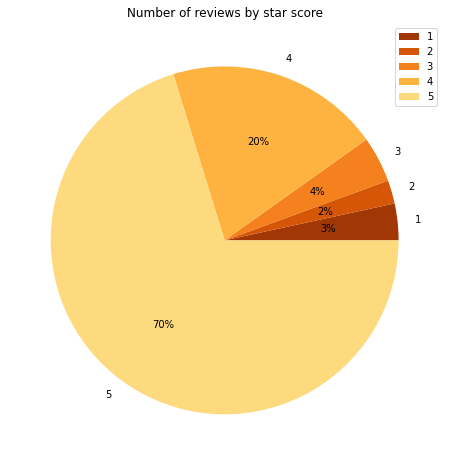

In [7]:
total_reviews = pd.DataFrame(df.groupby(df['reviews.rating.1'])['reviews.text'].agg('count'))

labels = total_reviews.index.to_list()
data = total_reviews['reviews.text']


plt.figure(figsize=(15,8))
colors = sns.color_palette('YlOrBr_r')[0:5]
plt.pie(data, labels = labels, colors = colors, autopct='%.0f%%')
plt.title("Number of reviews by star score")
plt.legend()
plt.show()

In [8]:
df.groupby(by=['primaryCategories','reviews.rating.1'])['reviews.text'].agg('count')

primaryCategories            reviews.rating.1
Animals & Pet Supplies       3                      1
                             4                      1
                             5                      4
Electronics                  1                    187
                             2                    183
                             3                    551
                             4                   3703
                             5                   9371
Electronics,Furniture        5                      2
Electronics,Media            1                      2
                             2                      2
                             3                      3
                             4                     42
                             5                    136
Health & Beauty              1                    751
                             2                    395
                             3                    534
                             4      

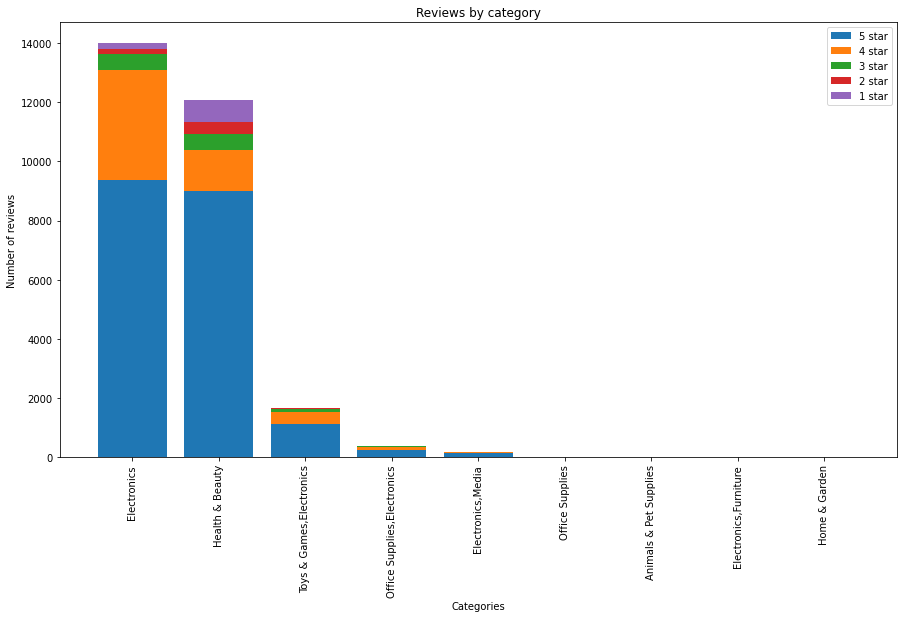

In [9]:
ratings_by_category = df.pivot_table(index= 'primaryCategories', 
                                           columns='reviews.rating.1', 
                                           values= 'reviews.text', 
                                           aggfunc='count').reset_index().fillna(0).sort_values(by=5, ascending=False)

one_star = ratings_by_category[1]
two_star = ratings_by_category[2]
three_star = ratings_by_category[3]
four_star = ratings_by_category[4]
five_star = ratings_by_category[5]
categories = ratings_by_category['primaryCategories']

plt.figure(figsize=(15,8))
plt.bar(categories, five_star, label= '5 star')
plt.bar(categories,four_star, bottom=five_star, label='4 star')
plt.bar(categories, three_star, bottom=(five_star+four_star), label='3 star')
plt.bar(categories, two_star, bottom=(five_star+four_star+three_star), label='2 star')
plt.bar(categories, one_star, bottom=(five_star+four_star+three_star+two_star), label='1 star')


plt.xlabel('Categories')
plt.ylabel('Number of reviews')
#plt.grid(b=None, which='major', axis='y')
plt.title("Reviews by category")
plt.legend()
plt.xticks(rotation=90)

plt.show()


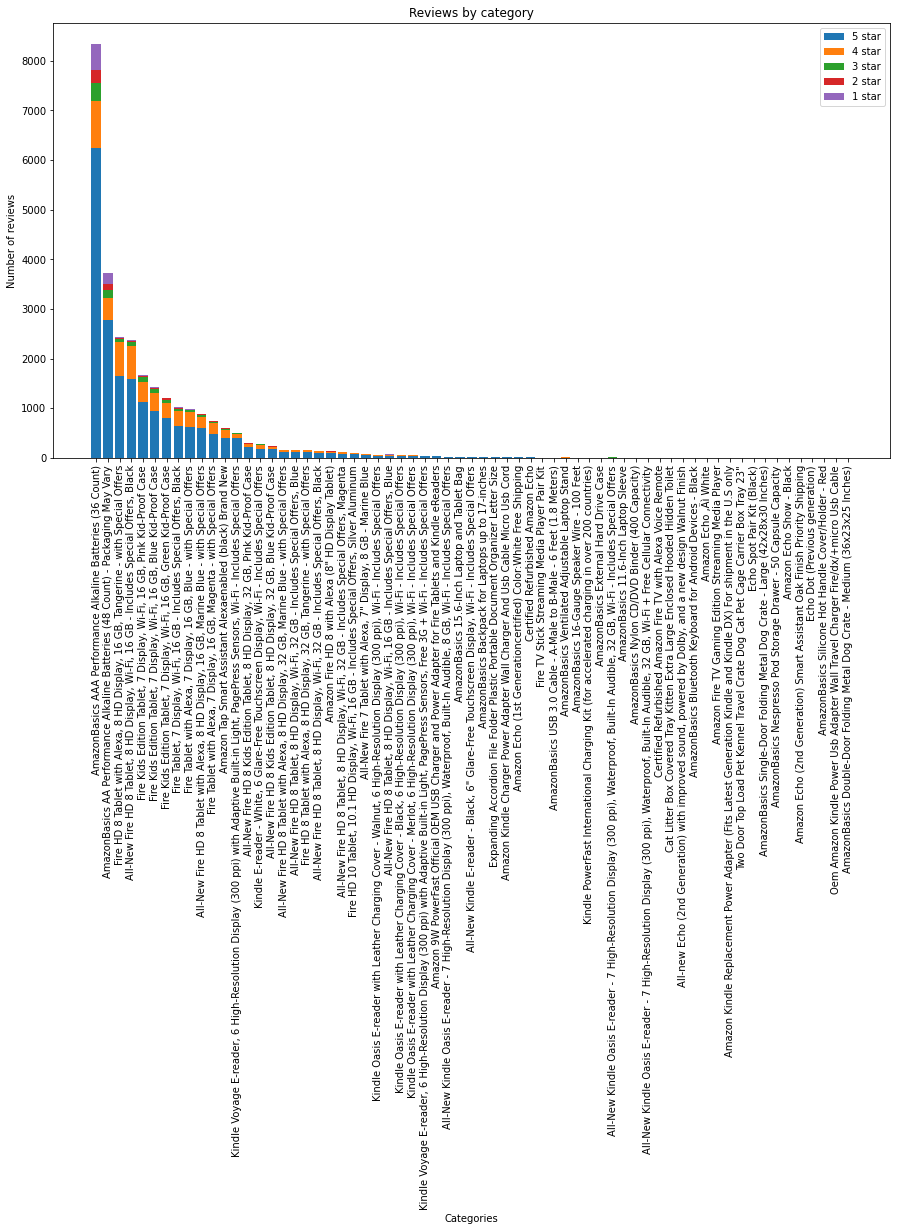

In [10]:
ratings_by_product = df.pivot_table(index= 'name', 
                                           columns='reviews.rating.1', 
                                           values= 'reviews.text', 
                                           aggfunc='count').reset_index().fillna(0).sort_values(by=5, ascending=False)

one_star = ratings_by_product[1]
two_star = ratings_by_product[2]
three_star = ratings_by_product[3]
four_star = ratings_by_product[4]
five_star = ratings_by_product[5]
categories = ratings_by_product['name']

plt.figure(figsize=(15,8))
plt.bar(categories, five_star, label= '5 star')
plt.bar(categories,four_star, bottom=five_star, label='4 star')
plt.bar(categories, three_star, bottom=(five_star+four_star), label='3 star')
plt.bar(categories, two_star, bottom=(five_star+four_star+three_star), label='2 star')
plt.bar(categories, one_star, bottom=(five_star+four_star+three_star+two_star), label='1 star')


plt.xlabel('Categories')
plt.ylabel('Number of reviews')
#plt.grid(b=None, which='major', axis='y')
plt.title("Reviews by category")
plt.legend()
plt.xticks(rotation=90)

plt.show()

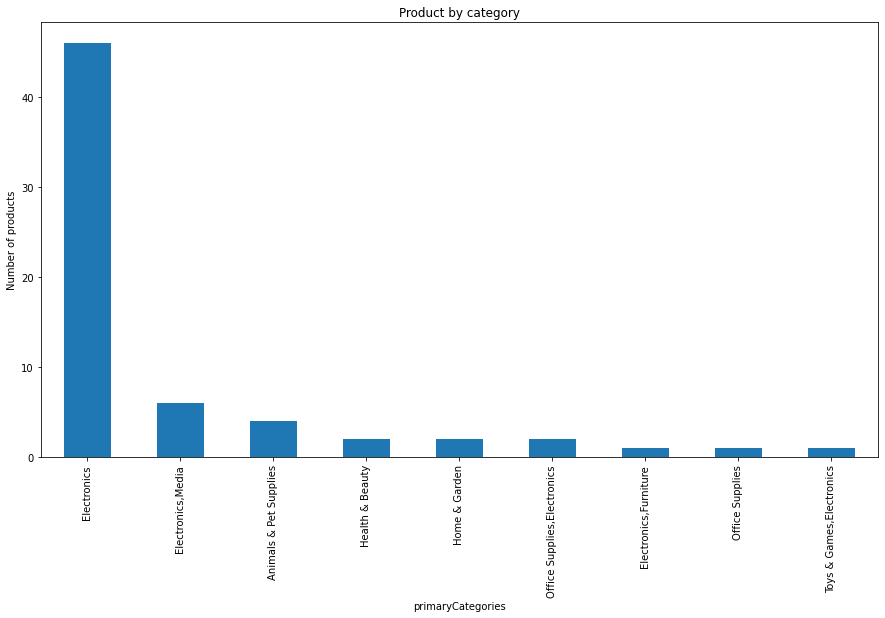

In [11]:
products_by_category = df.groupby(by=['primaryCategories'])['name'].agg('nunique').sort_values(ascending=False)

plt.figure(figsize=(15,8))

plt.xlabel('Category')
plt.ylabel('Number of products')
plt.grid(b=None, which='major', axis='y')
plt.title("Product by category")

products_by_category.plot(kind='bar')
plt.show()

# Data Cleaning and preparation

In [12]:
# Keep meaningful columns

clean_df = df[['asins', 'name', 'primaryCategories', 'reviews.rating.1', 'reviews.text']]

In [13]:
# Remove products with few reviews

reviews_by_product = df.groupby(df.name)['reviews.text'].agg('count').reset_index().sort_values(by='reviews.text', ascending=False)
high_reviewed_prods = reviews_by_product[reviews_by_product['reviews.text']>=50]['name'].unique().tolist()

clean_df = clean_df[clean_df['name'].isin(high_reviewed_prods)]

In [14]:
clean_df.name.unique()

array(['Amazon Tap Smart Assistant Alexaenabled (black) Brand New',
       'All-New Fire HD 8 Kids Edition Tablet, 8 HD Display, 32 GB, Blue Kid-Proof Case',
       'Amazon Fire HD 8 with Alexa (8" HD Display Tablet)',
       'All-New Fire HD 8 Tablet with Alexa, 8 HD Display, 16 GB, Marine Blue - with Special Offers',
       'All-New Fire HD 8 Kids Edition Tablet, 8 HD Display, 32 GB, Pink Kid-Proof Case',
       'Kindle E-reader - White, 6 Glare-Free Touchscreen Display, Wi-Fi - Includes Special Offers',
       'All-New Fire HD 8 Tablet with Alexa, 8 HD Display, 32 GB, Marine Blue - with Special Offers',
       'Kindle Voyage E-reader, 6 High-Resolution Display (300 ppi) with Adaptive Built-in Light, PagePress Sensors, Wi-Fi - Includes Special Offers',
       'All-New Fire 7 Tablet with Alexa, 7" Display, 8 GB - Marine Blue',
       'Fire Tablet, 7 Display, Wi-Fi, 16 GB - Includes Special Offers, Black',
       'AmazonBasics AAA Performance Alkaline Batteries (36 Count)',
       'Fir

In [15]:
clean_df.shape

(28031, 5)

# Sentiment analysis with TextBlob

In [16]:
# Getting text polarity and subjectivity

clean_df['polarity'] = [TextBlob(review).sentiment.polarity for review in clean_df['reviews.text'].tolist()]
clean_df['subjectivity'] = [TextBlob(review).sentiment.subjectivity for review in clean_df['reviews.text'].tolist()]

<AxesSubplot:xlabel='reviews.rating.1', ylabel='polarity'>

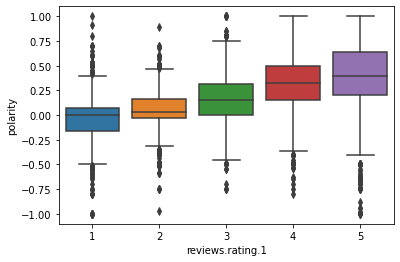

In [17]:
sns.boxplot(x=clean_df['reviews.rating.1'], y=clean_df['polarity'])

# Bag of words from reviews

In [18]:
product = 'AmazonBasics AAA Performance Alkaline Batteries (36 Count)'

product_reviews = clean_df[clean_df.name == product]

In [19]:
vect = CountVectorizer(max_features=1000, ngram_range=(1, 2), max_df=500, stop_words=ENGLISH_STOP_WORDS)

vect.fit(product_reviews['reviews.text'])

X_review = vect.transform(product_reviews['reviews.text'])

X_df = pd.DataFrame(X_review.toarray(), columns=vect.get_feature_names())

# Building wordcloud

/Users/miguel.d.ferrusca/Documents/ironhack/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='polarity'>

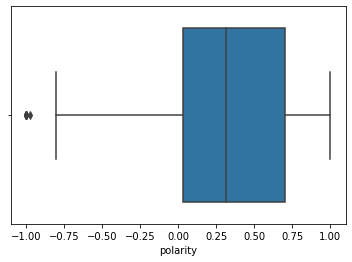

In [20]:
# understanding overall sentiment

sns.boxplot(product_reviews.polarity)

In [21]:
# get most common word of set of reviews

reviews = str([i for i in product_reviews['reviews.text']])
words= nltk.tokenize.word_tokenize(reviews)
reviews_words= [word for word in words if word.isalnum()]

counter = Counter(reviews_words)

top_words = [counter.most_common()[i][0] for i in range(0,20)]

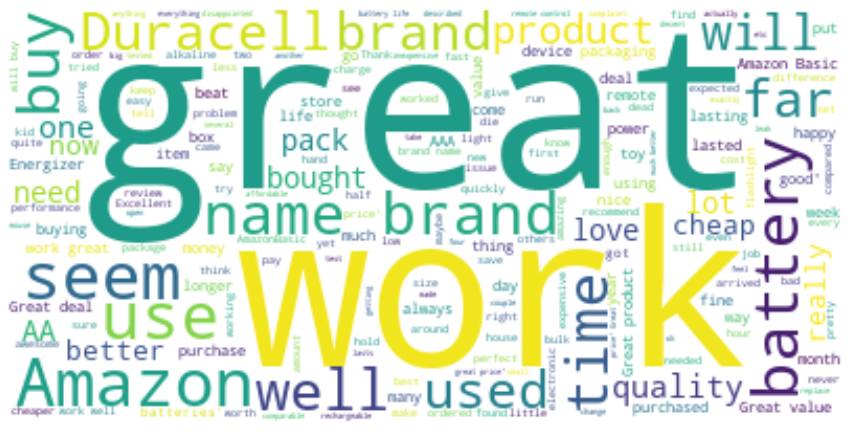

In [22]:
# updating stopwords with non meaningful words
my_stop_words = STOPWORDS.update(top_words)

#Create wordcloud
top_1_wordcloud = WordCloud(background_color='white', stopwords=my_stop_words).generate(reviews)

# Plot wordcloud
plt.figure(figsize=(15,8))
plt.imshow(top_1_wordcloud, interpolation='bilinear') 
plt.axis("off")
plt.show()

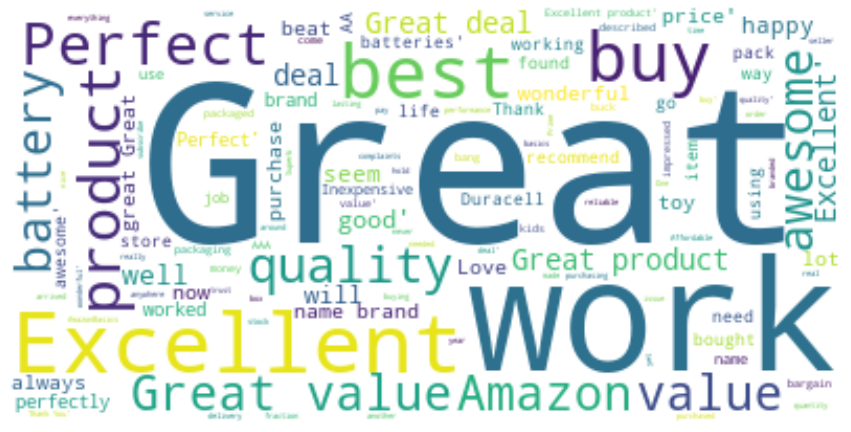

In [23]:
# positive reviews

positive_reviews = product_reviews[(product_reviews['polarity']>product_reviews['polarity'].quantile(.9))&
                                   (product_reviews['reviews.rating.1'].isin([4,5]))]

positive_reviews_string = str([i for i in positive_reviews['reviews.text']])

#Create wordcloud
cloud = WordCloud(background_color='white', stopwords=my_stop_words).generate(positive_reviews_string)

# Plot wordcloud
plt.figure(figsize=(15,8))
plt.imshow(cloud, interpolation='bilinear') 
plt.axis("off")
plt.show()

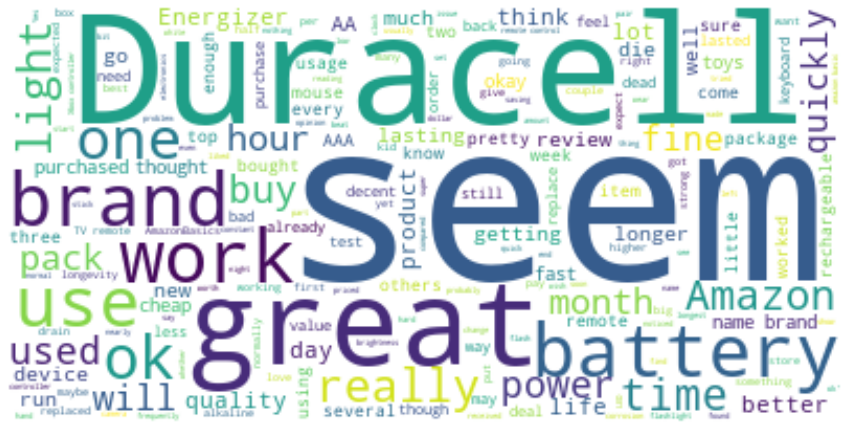

In [24]:
# neutral reviews

neutral_reviews = product_reviews[(product_reviews['polarity']>product_reviews['polarity'].quantile(.25))&
                                   (product_reviews['polarity']<product_reviews['polarity'].quantile(.75))&
                                   (product_reviews['reviews.rating.1'].isin([3]))]

neutral_reviews_string = str([i for i in neutral_reviews['reviews.text']])

#Create wordcloud
cloud = WordCloud(background_color='white', stopwords=my_stop_words).generate(neutral_reviews_string)

# Plot wordcloud
plt.figure(figsize=(15,8))
plt.imshow(cloud, interpolation='bilinear') 
plt.axis("off")
plt.show()

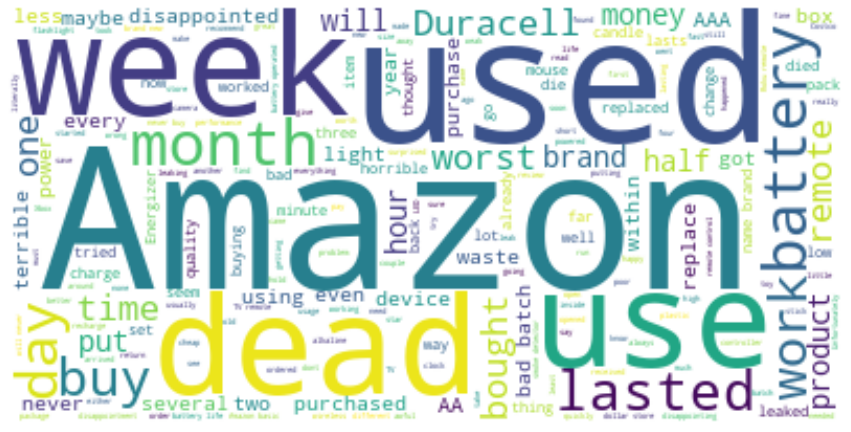

In [25]:
# negative reviews

negative_reviews = product_reviews[(product_reviews['polarity']<product_reviews['polarity'].quantile(.1))&
                                   (product_reviews['reviews.rating.1'].isin([1,2]))]


negative_reviews_string = str([i for i in negative_reviews['reviews.text']])

#Create wordcloud
cloud = WordCloud(background_color='white', stopwords=my_stop_words).generate(negative_reviews_string)

# Plot wordcloud
plt.figure(figsize=(15,8))
plt.imshow(cloud, interpolation='bilinear') 
plt.axis("off")
plt.show()

In [26]:
# wordcloud function

def plot_wordclouds_dataset(product):
    
    product_reviews = clean_df[clean_df.name == product]
    
    # updating stopwords for non meaningful words
    reviews = str([i for i in product_reviews['reviews.text']])
    words= nltk.tokenize.word_tokenize(reviews)
    reviews_words= [word for word in words if word.isalnum()]
    counter = Counter(reviews_words)
    top_words = [counter.most_common()[i][0] for i in range(0,20)]
    stopwords = STOPWORDS
    my_stop_words = stopwords.update(top_words)
    
    
    # plotting output
    figure, axis = plt.subplots(2, 2, figsize=(20,15))
    figure.suptitle(str('Analysis for: '+product), fontsize=20)
    
    
    #Plotting star review
    total_reviews = pd.DataFrame(product_reviews.groupby(product_reviews['reviews.rating.1'])['reviews.text'].agg('count'))
    labels = total_reviews.index.to_list()
    data = total_reviews['reviews.text']
    
    plt.figure(figsize=(15,8))
    colors = sns.color_palette('YlOrBr_r')[0:5]
    axis[0,0].pie(data, labels = labels, colors = colors, autopct='%.0f%%')
    axis[0,0].set_title("Number of reviews by star score", fontsize=15)
    axis[0,0].legend()    
    
    #plotting overall sentiment
    axis[0,1].hist(product_reviews.polarity)
    axis[0,1].set_title("Overall review sentiment", fontsize=15)
    
    
    #plotting negative reviews cloud
    negative_reviews = product_reviews[(product_reviews['polarity']<product_reviews['polarity'].quantile(.1))&
                                   (product_reviews['reviews.rating.1'].isin([1,2]))]
    
    negative_reviews_string = str([i for i in negative_reviews['reviews.text']])
    
    #Create negative wordcloud
    cloud = WordCloud(background_color='white', stopwords=my_stop_words).generate(negative_reviews_string)
    
    # Plot negative wordcloud
    axis[1,0].set_title("What negative reviews talk about...", fontsize=15)
    axis[1,0].imshow(cloud, interpolation='bilinear') 
    axis[1,0].axis("off")
    
    #plotting positive reviews cloud
    positive_reviews = product_reviews[(product_reviews['polarity']>product_reviews['polarity'].quantile(.9))&
                                   (product_reviews['reviews.rating.1'].isin([4,5]))]
    positive_reviews_string = str([i for i in positive_reviews['reviews.text']])
    
    #Create positive wordcloud
    cloud = WordCloud(background_color='white', stopwords=my_stop_words).generate(positive_reviews_string)
    
    # Plot positive wordcloud
    axis[1,1].set_title("What positive reviews talk about...", fontsize=15)
    axis[1,1].imshow(cloud, interpolation='bilinear') 
    axis[1,1].axis("off")
    
    plt.show()
    

In [27]:
products = ['Amazon Tap Smart Assistant Alexaenabled (black) Brand New',
       'All-New Fire HD 8 Kids Edition Tablet, 8 HD Display, 32 GB, Blue Kid-Proof Case',
       'Amazon Fire HD 8 with Alexa (8" HD Display Tablet)',
       'All-New Fire HD 8 Tablet with Alexa, 8 HD Display, 16 GB, Marine Blue - with Special Offers',
       'All-New Fire HD 8 Kids Edition Tablet, 8 HD Display, 32 GB, Pink Kid-Proof Case',
       'Kindle E-reader - White, 6 Glare-Free Touchscreen Display, Wi-Fi - Includes Special Offers',
       'All-New Fire HD 8 Tablet with Alexa, 8 HD Display, 32 GB, Marine Blue - with Special Offers',
       'Kindle Voyage E-reader, 6 High-Resolution Display (300 ppi) with Adaptive Built-in Light, PagePress Sensors, Wi-Fi - Includes Special Offers',
       'All-New Fire 7 Tablet with Alexa, 7" Display, 8 GB - Marine Blue',
       'Fire Tablet, 7 Display, Wi-Fi, 16 GB - Includes Special Offers, Black',
       'AmazonBasics AAA Performance Alkaline Batteries (36 Count)',
       'Fire HD 10 Tablet, 10.1 HD Display, Wi-Fi, 16 GB - Includes Special Offers, Silver Aluminum',
       'Fire Tablet with Alexa, 7 Display, 16 GB, Blue - with Special Offers',
       'All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, 16 GB - Includes Special Offers, Black',
       'Fire Kids Edition Tablet, 7 Display, Wi-Fi, 16 GB, Pink Kid-Proof Case',
       'Kindle Oasis E-reader with Leather Charging Cover - Black, 6 High-Resolution Display (300 ppi), Wi-Fi - Includes Special Offers',
       'Kindle Oasis E-reader with Leather Charging Cover - Merlot, 6 High-Resolution Display (300 ppi), Wi-Fi - Includes Special Offers',
       'Kindle Oasis E-reader with Leather Charging Cover - Walnut, 6 High-Resolution Display (300 ppi), Wi-Fi - Includes Special Offers',
       'AmazonBasics AA Performance Alkaline Batteries (48 Count) - Packaging May Vary',
       'Fire HD 8 Tablet with Alexa, 8 HD Display, 16 GB, Tangerine - with Special Offers',
       'All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, 32 GB - Includes Special Offers, Blue',
       'Fire Tablet with Alexa, 7 Display, 16 GB, Magenta - with Special Offers',
       'Fire HD 8 Tablet with Alexa, 8 HD Display, 32 GB, Tangerine - with Special Offers',
       'All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, 32 GB - Includes Special Offers, Black',
       'Fire Kids Edition Tablet, 7 Display, Wi-Fi, 16 GB, Blue Kid-Proof Case',
       'Fire Kids Edition Tablet, 7 Display, Wi-Fi, 16 GB, Green Kid-Proof Case',
       'All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, 32 GB - Includes Special Offers, Magenta',
       'All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, 16 GB - Includes Special Offers, Blue']

# Scraper

In [37]:
def scraper(asin):
    
    df = pd.DataFrame(columns=['rating', 'content'])
    pages = range(1,11)
    asin=asin
    
    for page in pages:
        
        print('Scraped {} page(s). Scraping page {}. Total reviews: {}'.format(page-1, page, len(df)))
        
        # iterable url
        url = 'https://www.amazon.com/product-reviews/{}/ref=cm_cr_getr_d_paging_btm_prev_1?pageNumber={}'.format(asin, page)
        
        # getting soup
        driver = webdriver.Chrome()
        driver.get(url)
        time.sleep(1)
        page_source = driver.page_source
        driver.quit()
        soup = BeautifulSoup(page_source,'lxml')
        
        # parsing soup
        reviews = soup.findAll("div", {"class":"a-section review aok-relative"})
        ## parsing reviews section
        reviews = BeautifulSoup('<br/>'.join([str(tag) for tag in reviews]), 'html.parser')
        
        #getting content
        contents = reviews.find_all("span", {"data-hook":"review-body"})
        content_lst = []
        for content in contents:
            text_ = content.find_all("span")[0].get_text("\n").strip()
            text_ = ". ".join(text_.splitlines())
            text_ = re.sub(' +', ' ', text_)
            content_lst.append(text_)
            
        #getting rating
        ratings = reviews.find_all("i", {"data-hook":"review-star-rating"})
        full_rating_lst = []
        for rating in ratings:
            full_rating_lst.append(rating.find_all("span")[0].contents[0])
            
        
        rating_lst = []
        for rating in full_rating_lst:
            rating_lst.append(re.findall("\d+\.\d+", rating)[0])
            
            
        # concatenating to main data frame
        
        temp_df = pd.DataFrame({'rating':rating_lst, 'content':content_lst})
        df = df.append(temp_df)
        
    return df


# WordCloud from Scrap

In [30]:
# wordcloud function

def plot_wordclouds_scrapper(product_reviews):
    
    # Getting text polarity and subjectivity
    product_reviews['polarity'] = [TextBlob(review).sentiment.polarity for review in product_reviews['content'].tolist()]
    product_reviews['subjectivity'] = [TextBlob(review).sentiment.subjectivity for review in product_reviews['content'].tolist()]
    
    # updating stopwords for non meaningful words
    reviews = str([i for i in product_reviews['content']])
    words= nltk.tokenize.word_tokenize(reviews)
    reviews_words= [word for word in words if word.isalnum()]
    counter = Counter(reviews_words)
    top_words = [counter.most_common()[i][0] for i in range(0,20)]
    stopwords = STOPWORDS
    my_stop_words = stopwords.update(top_words)
    
    
    # plotting output
    figure, axis = plt.subplots(2, 2, figsize=(20,15))    
    
    #Plotting star review
    total_reviews = pd.DataFrame(product_reviews.groupby(product_reviews['rating'])['content'].agg('count'))
    labels = total_reviews.index.to_list()
    data = total_reviews['content']
    
    plt.figure(figsize=(15,8))
    colors = sns.color_palette('YlOrBr_r')[0:5]
    axis[0,0].pie(data, labels = labels, colors = colors, autopct='%.0f%%')
    axis[0,0].set_title("Number of reviews by star score", fontsize=15)
    axis[0,0].legend()    
    
    #plotting overall sentiment
    axis[0,1].hist(product_reviews.polarity)
    axis[0,1].set_title("Overall review sentiment", fontsize=15)
    
    
    #plotting negative reviews cloud
    negative_reviews = product_reviews[(product_reviews['polarity']<product_reviews['polarity'].quantile(.1))]
    negative_reviews_string = str([i for i in negative_reviews['content']])
    cloud = WordCloud(background_color='white', stopwords=my_stop_words).generate(negative_reviews_string)
    
    # Plot negative wordcloud
    axis[1,0].set_title("What negative reviews talk about...", fontsize=15)
    axis[1,0].imshow(cloud, interpolation='bilinear') 
    axis[1,0].axis("off")
    
    #plotting positive reviews cloud
    positive_reviews = product_reviews[(product_reviews['polarity']>product_reviews['polarity'].quantile(.9))]
    positive_reviews_string = str([i for i in positive_reviews['content']])
    cloud = WordCloud(background_color='white', stopwords=my_stop_words).generate(positive_reviews_string)
    
    # Plot positive wordcloud
    axis[1,1].set_title("What positive reviews talk about...", fontsize=15)
    axis[1,1].imshow(cloud, interpolation='bilinear') 
    axis[1,1].axis("off")
    
    plt.show()
    

# Tests

In [31]:
test = scraper('B075PY25GG')

Scraped 0 page(s). Scraping page 1. Total reviews: 0
Scraped 1 page(s). Scraping page 2. Total reviews: 10
Scraped 2 page(s). Scraping page 3. Total reviews: 20
Scraped 3 page(s). Scraping page 4. Total reviews: 30
Scraped 4 page(s). Scraping page 5. Total reviews: 40


# Cluter

In [32]:
# wordcloud function

def plot_wordclouds_scrapper_bigram(product_reviews):
    
    # Getting text polarity and subjectivity
    product_reviews['polarity'] = [TextBlob(review).sentiment.polarity for review in product_reviews['content'].tolist()]
    product_reviews['subjectivity'] = [TextBlob(review).sentiment.subjectivity for review in product_reviews['content'].tolist()]
    
    # updating stopwords for non meaningful words
    reviews = str([i for i in product_reviews['content']])
    words= nltk.tokenize.word_tokenize(reviews)
    reviews_words= [word for word in words if word.isalnum()]
    counter = Counter(reviews_words)
    top_words = [counter.most_common()[i][0] for i in range(0,20)]
    stopwords = STOPWORDS
    my_stop_words = stopwords.update(top_words)
    
    
    # plotting output
    figure, axis = plt.subplots(2, 2, figsize=(20,15))    
    
    #Plotting star review
    total_reviews = pd.DataFrame(product_reviews.groupby(product_reviews['rating'])['content'].agg('count'))
    labels = total_reviews.index.to_list()
    data = total_reviews['content']
    
    plt.figure(figsize=(15,8))
    colors = sns.color_palette('YlOrBr_r')[0:5]
    axis[0,0].pie(data, labels = labels, colors = colors, autopct='%.0f%%')
    axis[0,0].set_title("Number of reviews by star score", fontsize=15)
    axis[0,0].legend()    
    
    #plotting overall sentiment
    axis[0,1].(product_reviews.polarity)
    axis[0,1].set_title("Overall review sentiment", fontsize=15)
    
    
    
    ######## plotting negative reviews cloud
    
    #getting negative reviews
    negative_reviews = product_reviews[(product_reviews['polarity']<product_reviews['polarity'].quantile(.1))]
    negative_reviews_string = str([i for i in negative_reviews['content']])
    
    negative_blob = TextBlob(negative_reviews_string)
    NounPhrases = negative_blob.noun_phrases
    # Creating an empty list to hold new values
    # combining the noun phrases using underscore to visualize it as wordcloud
    NewNounList=[]
    for words in NounPhrases:
        NewNounList.append(words.replace(" ", "_"))
        
    # Converting list into a string to plot wordcloud
    NegativeNewNounString=' '.join(NewNounList)
    
    negative_cloud = WordCloud(stopwords=my_stop_words, background_color='white').generate(NegativeNewNounString)
    
    # Plot negative wordcloud
    axis[1,0].set_title("What negative reviews talk about...", fontsize=15)
    axis[1,0].imshow(cloud, interpolation='bilinear') 
    axis[1,0].axis("off")
    
    
    
    ######## plotting positive reviews cloud
    
    #
    positive_reviews = product_reviews[(product_reviews['polarity']>product_reviews['polarity'].quantile(.9))]
    positive_reviews_string = str([i for i in positive_reviews['content']])
    
    positive_blob = TextBlob(positive_reviews_string)
    NounPhrases = positive_blob.noun_phrases
    # Creating an empty list to hold new values
    # combining the noun phrases using underscore to visualize it as wordcloud
    NewNounList=[]
    for words in NounPhrases:
        NewNounList.append(words.replace(" ", "_"))
        
    # Converting list into a string to plot wordcloud
    PositiveNewNounString=' '.join(NewNounList)
    
    positive_cloud = WordCloud(stopwords=my_stop_words, background_color='white').generate(PositiveNewNounString)
    
    # Plot negative wordcloud
    axis[1,0].set_title("What negative reviews talk about...", fontsize=15)
    axis[1,0].imshow(negative_cloud, interpolation='bilinear') 
    axis[1,0].axis("off")
    
    # Plot positive wordcloud
    axis[1,1].set_title("What positive reviews talk about...", fontsize=15)
    axis[1,1].imshow(positive_cloud, interpolation='bilinear') 
    axis[1,1].axis("off")
    
    plt.show()
    

Scraped 0 page(s). Scraping page 1. Total reviews: 0
Scraped 1 page(s). Scraping page 2. Total reviews: 10
Scraped 2 page(s). Scraping page 3. Total reviews: 20
Scraped 3 page(s). Scraping page 4. Total reviews: 30
Scraped 4 page(s). Scraping page 5. Total reviews: 40
Scraped 5 page(s). Scraping page 6. Total reviews: 50
Scraped 6 page(s). Scraping page 7. Total reviews: 60
Scraped 7 page(s). Scraping page 8. Total reviews: 70
Scraped 8 page(s). Scraping page 9. Total reviews: 80
Scraped 9 page(s). Scraping page 10. Total reviews: 90


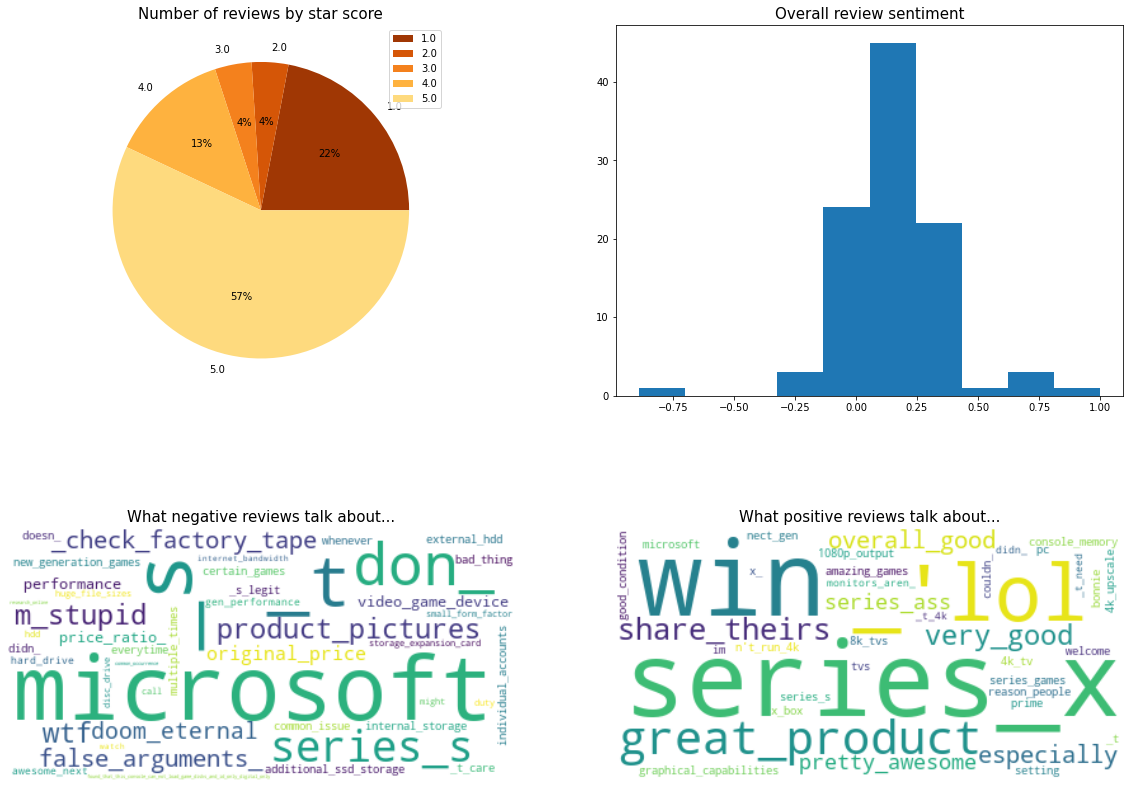

<Figure size 1080x576 with 0 Axes>

In [38]:
plot_wordclouds_scrapper_bigram(scraper('B08G9J44ZN'))

In [ ]:
# wordcloud function

def plot_wordclouds_scrapper(product_reviews):
    
    # Getting text polarity and subjectivity
    product_reviews['polarity'] = [TextBlob(review).sentiment.polarity for review in product_reviews['content'].tolist()]
    product_reviews['subjectivity'] = [TextBlob(review).sentiment.subjectivity for review in product_reviews['content'].tolist()]
    
    # updating stopwords for non meaningful words
    reviews = str([i for i in product_reviews['content']])
    words= nltk.tokenize.word_tokenize(reviews)
    reviews_words= [word for word in words if word.isalnum()]
    counter = Counter(reviews_words)
    top_words = [counter.most_common()[i][0] for i in range(0,20)]
    stopwords = STOPWORDS
    my_stop_words = stopwords.update(top_words)
    
    
    # plotting output
    figure, axis = plt.subplots(2, 2, figsize=(20,15))    
    
    #Plotting star review
    total_reviews = pd.DataFrame(product_reviews.groupby(product_reviews['rating'])['content'].agg('count'))
    labels = total_reviews.index.to_list()
    data = total_reviews['content']
    
    plt.figure(figsize=(15,8))
    colors = sns.color_palette('YlOrBr_r')[0:5]
    axis[0,0].pie(data, labels = labels, colors = colors, autopct='%.0f%%')
    axis[0,0].set_title("Number of reviews by star score", fontsize=15)
    axis[0,0].legend()    
    
    #plotting overall sentiment
    axis[0,1].hist(product_reviews.polarity)
    axis[0,1].set_title("Overall review sentiment", fontsize=15)
    
    
    #plotting negative reviews cloud
    negative_reviews = product_reviews[(product_reviews['polarity']<product_reviews['polarity'].quantile(.1))&
                                   (product_reviews['rating'].isin([1,2]))]
    negative_reviews_string = str([i for i in negative_reviews['content']])
    cloud = WordCloud(background_color='white', stopwords=my_stop_words).generate(negative_reviews_string)
    
    # Plot negative wordcloud
    axis[1,0].set_title("What negative reviews talk about...", fontsize=15)
    axis[1,0].imshow(cloud, interpolation='bilinear') 
    axis[1,0].axis("off")
    
    #plotting positive reviews cloud
    positive_reviews = product_reviews[(product_reviews['polarity']>product_reviews['polarity'].quantile(.9))&
                                   (product_reviews['rating'].isin([4,5]))]
    positive_reviews_string = str([i for i in positive_reviews['content']])
    cloud = WordCloud(background_color='white', stopwords=my_stop_words).generate(positive_reviews_string)
    
    # Plot positive wordcloud
    axis[1,1].set_title("What positive reviews talk about...", fontsize=15)
    axis[1,1].imshow(cloud, interpolation='bilinear') 
    axis[1,1].axis("off")
    
    plt.show()
    

In [ ]:
# Plotting wordcloud for product with the most reviews

#Getting reviews for top 1 product and creating a string of words
top_1_reviews = clean_df[clean_df['name']=='AmazonBasics AAA Performance Alkaline Batteries (36 Count)']['reviews.text'].tolist()
top_1_reviews_string = ' '.join(top_1_reviews)

#load stop wwords
stopwords = nltk.corpus.stopwords.words('english')

#Create wordcloud
top_1_wordcloud = WordCloud(background_color='white', stopwords=stopwords).generate(top_1_reviews_string)

# Plot wordcloud
plt.figure(figsize=(15,8))
plt.imshow(top_1_wordcloud, interpolation='bilinear') 
plt.axis("off")
plt.show()

In [ ]:
# Plotting wordcloud for product with the most reviews

#Getting reviews for top 1 product and creating a string of words
top_1_reviews = clean_df[clean_df['asins']=='B01J94SWWU']['reviews.text'].tolist()
top_1_reviews_string = ' '.join(top_1_reviews)

#load stop wwords
stopwords = nltk.corpus.stopwords.words('english')

#Create wordcloud
top_1_wordcloud = WordCloud(background_color='white', stopwords=stopwords).generate(top_1_reviews_string)

# Plot wordcloud
plt.figure(figsize=(15,8))
plt.imshow(top_1_wordcloud, interpolation='bilinear') 
plt.axis("off")
plt.show()

In [ ]:
clean_df.info()

In [ ]:
reduced_df = clean_df[['asins', 'name', 'reviews.rating.1', 'reviews.text']]

In [ ]:
# Getting text polarity and subjectivity

reduced_df['polarity'] = [TextBlob(review).sentiment.polarity for review in reduced_df['reviews.text'].tolist()]
reduced_df['subjectivity'] = [TextBlob(review).sentiment.subjectivity for review in reduced_df['reviews.text'].tolist()]

In [ ]:
top_1_asin_positive_reviews = reduced_df[
    (reduced_df['asins']=='B018T075DC') & 
    (reduced_df['polarity'] > .33)]['reviews.text'].tolist()

top_1_asin_positive_reviews_string = ' '.join(top_1_asin_positive_reviews)


top_1_asin_negative_reviews = reduced_df[
    (reduced_df['asins']=='B018T075DC') & 
    (reduced_df['polarity'] < -.33)]['reviews.text'].tolist()

top_1_asin_negative_reviews_string = ' '.join(top_1_asin_negative_reviews)

In [ ]:
#load stop wwords
stopwords = nltk.corpus.stopwords.words('english')

#Create positive wordcloud
top_1_positive_wordcloud = WordCloud(background_color='white', stopwords=stopwords).generate(top_1_asin_positive_reviews_string)

# Plot wordcloud
plt.figure(figsize=(15,8))
plt.imshow(top_1_positive_wordcloud, interpolation='bilinear') 
plt.axis("off")
plt.show()



#Create negative wordcloud
top_1_negative_wordcloud = WordCloud(background_color='white', stopwords=stopwords).generate(top_1_asin_negative_reviews_string)

# Plot wordcloud
plt.figure(figsize=(15,8))
plt.imshow(top_1_negative_wordcloud, interpolation='bilinear') 
plt.axis("off")
plt.show()



In [ ]:
reduced_df.groupby(reduced_df['asins'])['reviews.text'].agg('count').sort_values(ascending=False)

In [ ]:
clean_df[clean_df['name'] == 'AmazonBasics AAA Performance Alkaline Batteries (36 Count)']

In [ ]:
sns.boxplot(x=reduced_df['reviews.rating.1'], y=reduced_df['polarity'])